# Hypothesis testing for US Health Insurance Dataset

Shenyue Jia

In [25]:
import json
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scipy
scipy.__version__

'1.9.3'

## Data

US Health Insurance Dataset from [Kaggle](https://www.kaggle.com/teertha/ushealthinsurancedataset)

In [2]:
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQBN8DPW2rdiRrY34eEM53HAzakNGSRrw4ogI-j8HyCUrbqTB_z4CeIn2IvjLF-w_6sOe5pIlypJGAA/pub?output=csv'
df = pd.read_csv(url)

In [3]:
# inspect data
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 1. Do smokers have higher insurance charges than non-smokers? 

### 1.1 State your Null Hypothesis and Alternative Hypothesis

- Null Hypothesis ($H_0$)
    - Smokers do not have a higher insurance charge than non-smokers.
- Alternative Hypothesis ($H_1$)
    - Smokers have a significantly different level of (higher) insurance charge than non-smokers.

### 1.2 Select the correct test according to the data type and number of samples

- Type of Data
    - `charges` column is numeric data
- How many groups/samples?
    - 2 groups (smokers vs. non-smokers)
- Therefore, which test is appropriate?
    - 2 sample t test

### 1.3 Test the assumptions of your selected test

In [4]:
## Drop null values from related columns
df = df.dropna(subset=['smoker','charges'])

In [5]:
# Add an id field as index
ids = list(range(0,df.shape[0]))
df['id'] = ids

# set id as index
df = df.set_index('id')
df.head()

,age,sex,bmi,children,smoker,region,charges
id,,,,,,,
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
## save list of columns needed for each group
needed_cols = ['smoker','charges']
df[needed_cols]

,smoker,charges
id,,
0,yes,16884.92400
1,no,1725.55230
2,no,4449.46200
3,no,21984.47061
4,no,3866.85520
...,...,...
1333,no,10600.54830
1334,no,2205.98080
1335,no,1629.83350


In [7]:
## save male team in separate variable
sm_df = df.loc[ df['smoker']=='yes', needed_cols]
nsm_df = df.loc[ df['smoker']=='no', needed_cols]

In [8]:
## Make a df just for visualization by concat the groups 
plot_df =  pd.concat([sm_df,nsm_df])
plot_df

,smoker,charges
id,,
0,yes,16884.9240
11,yes,27808.7251
14,yes,39611.7577
19,yes,36837.4670
23,yes,37701.8768
...,...,...
1332,no,11411.6850
1333,no,10600.5483
1334,no,2205.9808


<AxesSubplot: xlabel='smoker', ylabel='charges'>

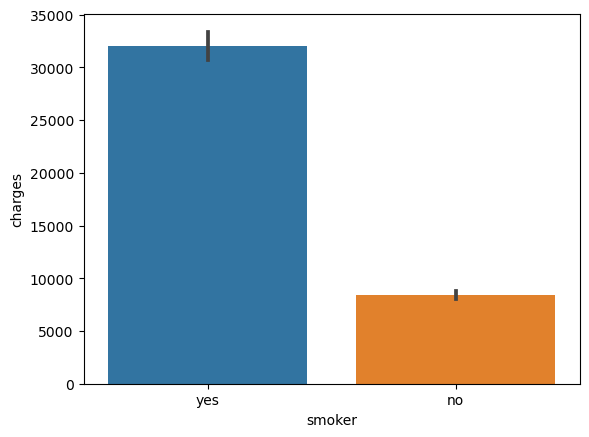

In [9]:
## visualize the group means
sns.barplot(data=plot_df, y='charges',x='smoker')

- From the bar plot, we can find these two groups have a great difference in insurance charges
- We may reject the $H_0$

### 1.4 Execute the selected test

#### Remove outliers

In [10]:
## Saving JUST the numeric col as final group variables
sm_group = sm_df['charges']
nsm_group = nsm_df['charges']
sm_group

id
0       16884.92400
11      27808.72510
14      39611.75770
19      36837.46700
23      37701.87680
           ...     
1313    36397.57600
1314    18765.87545
1321    28101.33305
1323    43896.37630
1337    29141.36030
Name: charges, Length: 274, dtype: float64

In [11]:
## Check smoker group for outliers
sm_outliers = np.abs(stats.zscore(sm_group)) > 3
sm_outliers.sum()

0

In [12]:
## Check non-smoker group for outliers
nsm_outliers = np.abs(stats.zscore(nsm_group)) > 3
nsm_outliers.sum()

24

In [13]:
## remove outliers from non-smoker group
nsm_group = nsm_group.loc[~nsm_outliers]
nsm_group

id
1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
5        3756.62160
           ...     
1332    11411.68500
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
Name: charges, Length: 1040, dtype: float64

In [14]:
# check how many outliers were removed
len(nsm_df),len(nsm_group)

(1064, 1040)

#### Test normality

<AxesSubplot: xlabel='charges', ylabel='Density'>

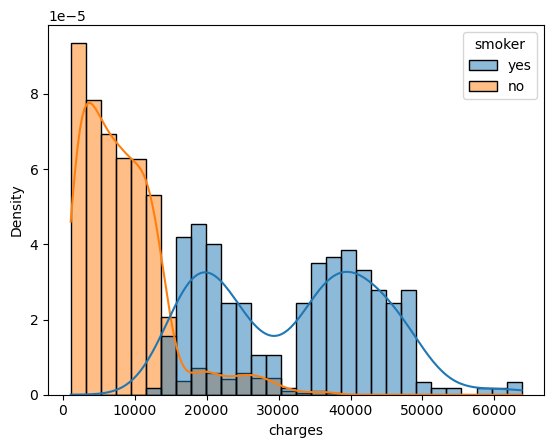

In [15]:
## Make figure and plot histogram
## visualize the histobram of charges by smokers
sns.histplot(data=df, x='charges',hue='smoker',common_norm=False, 
             stat='density',kde=True)

In [16]:
## Check smoker group for normality
result = stats.normaltest(sm_group)
alpha = .05

if result.pvalue < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected. \nData does not come from a normal distribution.")
else:
    print("The null hypothesis cannot be rejected. \nData comes from a normal distribution")

The null hypothesis can be rejected. 
Data does not come from a normal distribution.


In [17]:
## Check n for smoker group
len(sm_group)

274

In [18]:
## Check non-smoker group for normality
result = stats.normaltest(nsm_group)
alpha = .05

if result.pvalue < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected. \nData does not come from a normal distribution.")
else:
    print("The null hypothesis cannot be rejected. \nData comes from a normal distribution")

The null hypothesis can be rejected. 
Data does not come from a normal distribution.


In [19]:
len(nsm_group)

1040

- p-values for normality test of both smoker group and non-smoker group are < 0.05
    - Reject the $H_0$ for normality test (data come from a normal distribution)
- Data of smoker group and non-smoker group **DOS NOT** come from a normal distribution
- Our group sizes (n) are large enough (> 15 per group), we can safely ignore the normality assumption.

#### Test for equal variance

In [20]:
## Use Levene's test for equal variance
result = stats.levene(sm_group, nsm_group)
print(result)

LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)


In [21]:
## Use an if-else to help interpret the p-value
## Use an if-else to help interpret the p-value
if result.pvalue < .05:
    print(f"The groups do NOT have equal variance.")
else:
    print(f"The groups DO have equal variance.")

The groups do NOT have equal variance.


### 1.5 Final hypothesis test

From the above tests, we know
- Both groups do not follow a normal distribution but our sample size is large enough to ignore the normality test result
- Groups do **NOT** have equal variance
    - **Use a Welch's T-Test**

In [22]:
result = stats.ttest_ind(sm_group, nsm_group, equal_var=False)
print(result)

Ttest_indResult(statistic=33.732305987092516, pvalue=2.575322662587431e-104)


In [23]:
alpha = 0.05
if result.pvalue < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected. \nMedical insurance of smokers is significantly different from non-smokers.")
else:
    print("The null hypothesis cannot be rejected. \nMedical insurance of smokers is **NOT** significantly different from non-smokers")

The null hypothesis can be rejected. 
Medical insurance of smokers is significantly different from non-smokers.


### 1.6 Understand the result

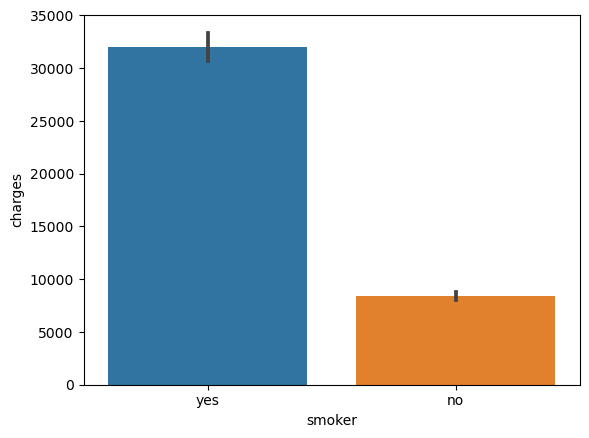

In [26]:
## visualize the group means
sns.barplot(data=plot_df, y='charges',x='smoker')

## Save PNG
FOLDER = "PNG/"
isExist = os.path.exists(FOLDER)
    
if isExist == False:  
    os.makedirs(FOLDER, exist_ok=True)
        
plt.savefig(f'{FOLDER}/smoker_charges_bar.png',bbox_inches='tight')

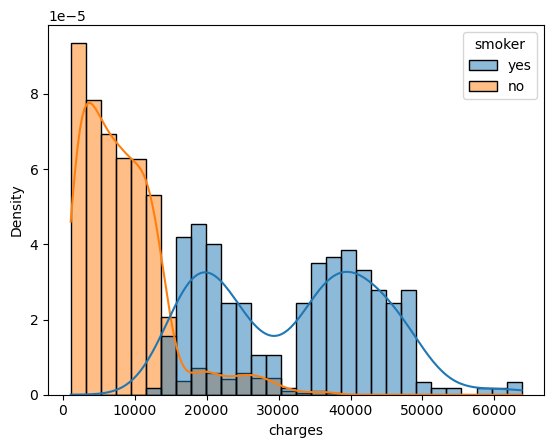

In [27]:
## visualize the histobram of charges by smokers
sns.histplot(data=df, x='charges',hue='smoker',common_norm=False, 
             stat='density',kde=True)

## Save PNG
FOLDER = "PNG/"
isExist = os.path.exists(FOLDER)
    
if isExist == False:  
    os.makedirs(FOLDER, exist_ok=True)
        
plt.savefig(f'{FOLDER}/smoker_charges_hist.png',bbox_inches='tight')

- The above visualizations and the t-test results indicate that:
    - Smokers have a signficantly different medical insurance charge than non-smokers
    - Medical insurance charges for smokers are **higher** than non-smokers

## 2. Are men more likely to smoke than women?

### 2.1 State your Null Hypothesis and Alternative Hypothesis

- Null Hypothesis ($H_0$)
    - Men are not more likely to smoke than women.
- Alternative Hypothesis ($H_1$)
    - Men have a significantly different chance of (higher) to smoke than women.

### 2.2 Select the correct test according to the data type and number of samples

- Type of Data
    - `sex` column is categorical data
- How many groups/samples?
    - 2 groups (men vs. women)
- Therefore, which test is appropriate?
    - Chi-square test

### 2.3 Test the assumptions of your selected test

In [28]:
## Drop null values from related columns
df = df.dropna(subset=['smoker','sex'])

In [29]:
## save list of columns needed for each group
needed_cols = ['smoker','sex']
df[needed_cols]

,smoker,sex
id,,
0,yes,female
1,no,male
2,no,male
3,no,male
4,no,male
...,...,...
1333,no,male
1334,no,female
1335,no,female


In [30]:
## save male team in separate variable
female_df = df.loc[ df['sex']=='female', needed_cols]
male_df = df.loc[ df['sex']=='male', needed_cols]

In [31]:
## Make a df just for visualization by concat the groups 
plot_df =  pd.concat([female_df,male_df])
plot_df

,smoker,sex
id,,
0,yes,female
5,no,female
6,no,female
7,no,female
9,no,female
...,...,...
1324,no,male
1325,no,male
1327,no,male


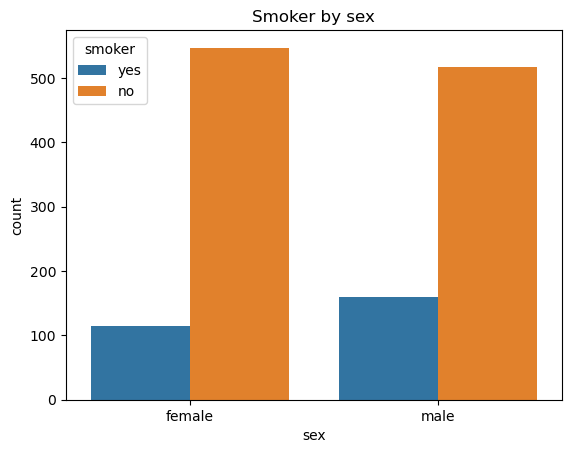

In [32]:
## visualize the group means
ax = sns.countplot(data=plot_df, x='sex',hue='smoker',)
ax.set_title("Smoker by sex");

### 2.4 Execute the selected test

In [33]:
# calculate the contingency table with pd.cross-tab
table = pd.crosstab(plot_df['sex'], plot_df['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


In [34]:
# Run the Test and Save the Output
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result #this labels the results

In [35]:
# What was our p-value?
alpha = 0.05
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected. \nThe number of male smokers is significantly different from female.")
else:
    print("The null hypothesis cannot be rejected. \nThere is no significant difference in the number of smokers between male and female.")

The null hypothesis can be rejected. 
The number of male smokers is significantly different from female.


### 2.5 Understand the result

- The above results indicated that we can reject the null hypothesis ($H_0$), indicating there is a significant difference between the number of smokers in male and female.
- Based on the bar plot below, we can infer that the number of smokers in male is **significantly larger** than female

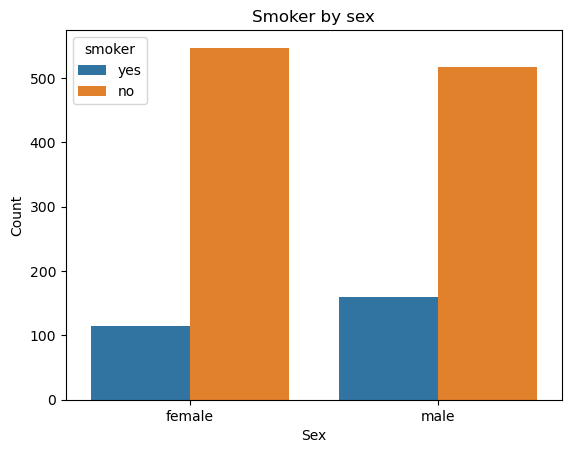

In [36]:
## visualize the group means
ax = sns.countplot(data=plot_df, x='sex',hue='smoker',)
ax.set_xlabel('Sex')
ax.set_ylabel('Count')
ax.set_title("Smoker by sex");

## Save PNG
FOLDER = "PNG/"
isExist = os.path.exists(FOLDER)
    
if isExist == False:  
    os.makedirs(FOLDER, exist_ok=True)
        
plt.savefig(f'{FOLDER}/smoker_sex_bar.png',bbox_inches='tight')

## 3. Do different regions have different charges, on average?

### 3.1 State your Null Hypothesis and Alternative Hypothesis

- Null Hypothesis ($H_0$)
    - Different regions do not have different charges on average
- Alternative Hypothesis ($H_1$)
    - Insurance charges are different across regions

### 3.2 Select the correct test according to the data type and number of samples

- Type of Data
    - `charge` column is numeric data
- How many groups/samples?
    - Four groups (`region`)
- Therefore, which test is appropriate?
    - ANOVA

In [37]:
df['region'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

### 3.3 Test the assumptions of your selected test

In [38]:
## Drop null values from related columns
df = df.dropna(subset=['charges','region'])

In [39]:
## save list of columns needed for each group
needed_cols = ['charges','region']
plot_df = df[needed_cols]
plot_df.head()

,charges,region
id,,
0,16884.92400,southwest
1,1725.55230,southeast
2,4449.46200,southeast
3,21984.47061,northwest
4,3866.85520,northwest


#### Separating groups

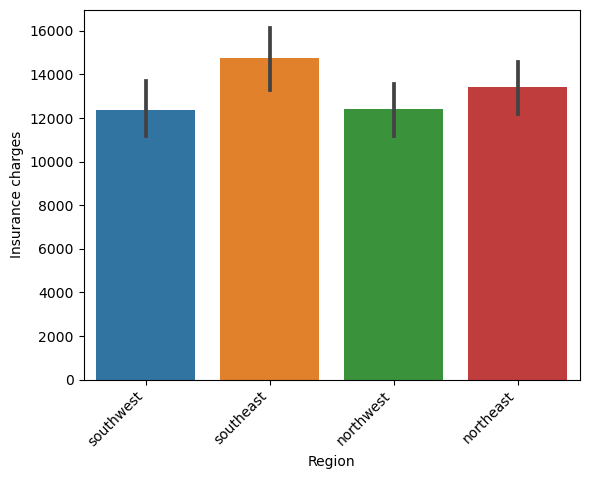

In [40]:
## visualize the group means
ax = sns.barplot(data=df, x='region', y='charges')
ax.set_xlabel('Region')
ax.set_ylabel('Insurance charges')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');

## Save PNG
FOLDER = "PNG/"
isExist = os.path.exists(FOLDER)
    
if isExist == False:  
    os.makedirs(FOLDER, exist_ok=True)
        
plt.savefig(f'{FOLDER}/region_charges_barplot.png',bbox_inches='tight')

In [41]:
## Create a dictionary with each group as key and funded_amount as values
groups ={}

for sector in df['region'].unique():
    temp = df.loc[df['region']== sector, 'charges']
    groups[sector] = temp

groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

### 3.4 Testing assumptions

#### Assumption of No Sig. Outliers

In [42]:
## Loop through groups dict
for sector, data in groups.items():

    ## determine if there are any outliers
    outliers = np.abs(stats.zscore(data)) > 3
    
    ## print a statement about how many outliers for which group name
    print(f"There were {outliers.sum()} outliers in the {sector} group.")

    ## Remove the outiers from data and overwrite the sector data in the dict
    data = data.loc[~outliers]
    groups[sector] = data

There were 8 outliers in the southwest group.
There were 2 outliers in the southeast group.
There were 7 outliers in the northwest group.
There were 4 outliers in the northeast group.


#### Assumption of normality

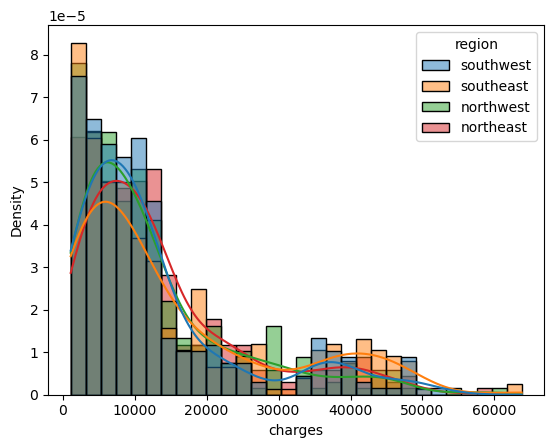

In [43]:
## Make figure and plot histogram
## visualize the histobram of charges by regions
sns.histplot(data=df, x='charges',hue='region',common_norm=False, 
             stat='density',kde=True)

## Save PNG
FOLDER = "PNG/"
isExist = os.path.exists(FOLDER)
    
if isExist == False:  
    os.makedirs(FOLDER, exist_ok=True)
        
plt.savefig(f'{FOLDER}/region_charges_hist.png',bbox_inches='tight')

In [47]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T

### checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
southwest,317.0,7.728611e-22,97.223886,True
southeast,362.0,1.936990e-13,58.544942,True
northwest,318.0,2.940543e-19,85.341045,True
northeast,320.0,3.557877e-17,75.749565,True


- Although p values are all below 0.05 and we reject the null hypothesis of normality, the number of data points in our data is large enough for each group (> 15)
- We can consider that our data satisfies the assumption of normality

#### Testing assumption of equal variance

In [48]:
## Use Levene's test for equal variance
result = stats.levene(*groups.values())
print(result)

LeveneResult(statistic=9.518349004554441, pvalue=3.2035503711783993e-06)


In [49]:
## Use an if-else to help interpret the p-value
if result.pvalue < .05:
    print(f"The groups do NOT have equal variance.")
else:
    print(f"The groups DO have equal variance.")

The groups do NOT have equal variance.


- We met the assumption of normality but did NOT meet the assumption of equal variance.
- One-way ANOVA is usually robust against violations of the equal variance assumption for group with same sample size, **which is NOT our case**
- We wanted to run an ANOVA test but will need to use a Kurskal-Wallis test instead.

### 3.5 Final hypothesis test

In [50]:
## Running Krukal Test for Original Hypothesis
result = stats.kruskal(*groups.values())
print(result)
result.pvalue<.05

KruskalResult(statistic=6.914045702545643, pvalue=0.07468847911322242)


False

- Our Kruskal Wallis test returned a p-value greater than 0.05. We cannot reject the null hypothesis and conclude that there is **not** a significant difference between insurance charges for different regions.

### 3.6 (Optional) Post-hoc multiple comparison test

- Although Kurskal-Wallis test indicated that there is no significant difference between regions in terms of insurance charges, our histogram showed that the `southeast` and `northeast` groups have a different shape of KDE curve.
- We can apply post-hot multiple comparison test to compare regions in pairs

In [51]:
# use the following dataframe for post-hoc multiple comparison test
plot_df

,charges,region
id,,
0,16884.92400,southwest
1,1725.55230,southeast
2,4449.46200,southeast
3,21984.47061,northwest
4,3866.85520,northwest
...,...,...
1333,10600.54830,northwest
1334,2205.98080,northeast
1335,1629.83350,southeast


In [52]:
## save the values as kg_lost and the labels to the Diet
values = plot_df['charges']
labels = plot_df['region']

## perform tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
northeast,northwest,-988.8091,0.7245,-3428.9343,1451.3161,False
northeast,southeast,1329.0269,0.4745,-1044.9417,3702.9955,False
northeast,southwest,-1059.4471,0.6792,-3499.5723,1380.6781,False
northwest,southeast,2317.8361,0.0583,-54.1994,4689.8716,False
northwest,southwest,-70.638,0.9999,-2508.8826,2367.6066,False
southeast,southwest,-2388.4741,0.0477,-4760.5096,-16.4386,True


- There is a significant difference in `charges` between `southeast` and `southwest`
- No significant difference was found in all the other region pairs

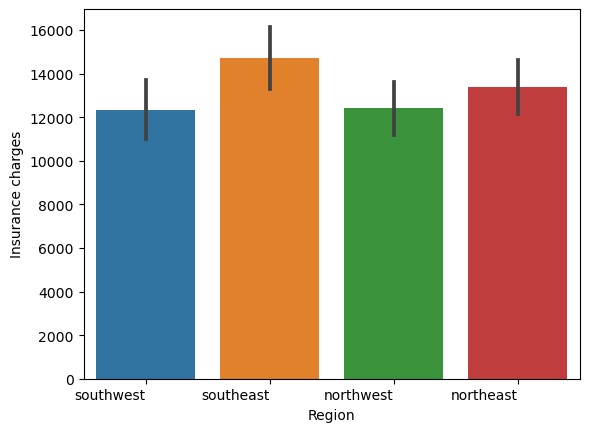

In [53]:
## make a barplot of final data to go with results
ax = sns.barplot(data=plot_df, x='region', y='charges')
ax.set_xlabel('Region')
ax.set_ylabel('Insurance charges')
ax.set_xticklabels(ax.get_xticklabels(), ha='right');

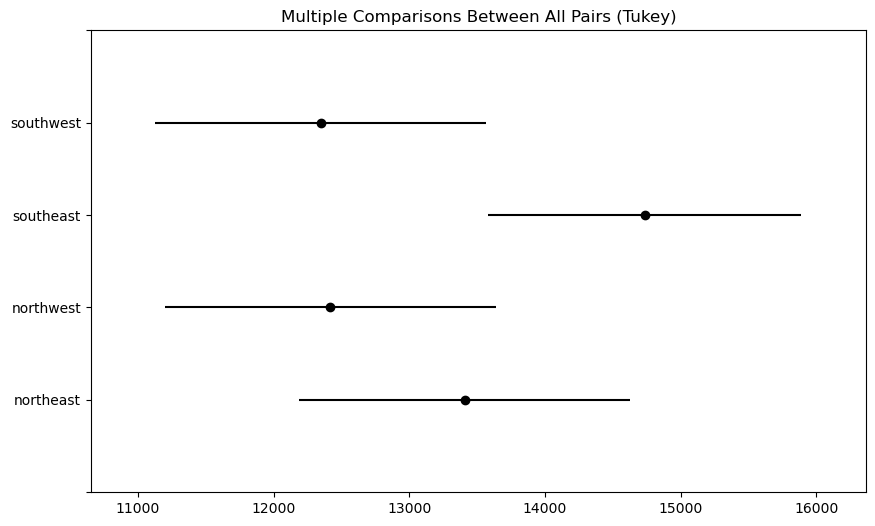

In [55]:
## also can use built-in plot tukeys_reuslts.plot_simultaneous
tukeys_results.plot_simultaneous();

## Save PNG
FOLDER = "PNG/"
isExist = os.path.exists(FOLDER)
    
if isExist == False:  
    os.makedirs(FOLDER, exist_ok=True)
        
plt.savefig(f'{FOLDER}/region_charges_tukey.png',bbox_inches='tight')